**Below are the steps to load the csv file from google drive to colab**



In [0]:
# Loading the Amazon Fine Food Reviews dataset into Google colab
#Refer:https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
#Refere:https://www.youtube.com/watch?v=oqMImCeXi6o

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# Right click on the Reviews dataset in the Drive and click"Get shareable link" so that it will be copied to the clipboard
#create a variable link and paste the link.Copy the Id after "="
link='https://drive.google.com/open?id=1dc2S8bQbUNMbGInMQYmYiajVwH_9iylX'
fluff, id = link.split('=')
print(id) # Verify that you have everything after '='

1dc2S8bQbUNMbGInMQYmYiajVwH_9iylX


In [0]:
# Reading the Amazon Fine Food Reviews dataset into colab
import pandas as pd
downloaded = drive.CreateFile({'id':'1dc2S8bQbUNMbGInMQYmYiajVwH_9iylX'}) 
downloaded.GetContentFile('database.sqlite')  


**Reading the Amazon Fine Food Reviews dataset into Colab**

In [0]:
# Importing necessary libraries

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [7]:

# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 


# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [8]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries 
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


**Observation:-**
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [15]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ..."
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...


**Prerpocessing Review Text**
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags Remove any punctuations or limited set of special characters like , or . or # etc. Check if the word is made up of english letters and is not alpha-numeric Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters) Convert the word to lowercase Remove Stopwords Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming) After which we collect the words used to describe positive and negative reviews

In [0]:
# Importing necessary libraries

from bs4 import BeautifulSoup
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [18]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)# To remove urls
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()# To remove numbers
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) # To remove special characters
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)# To convert to lower case letters
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:30<00:00, 2834.04it/s]


In [0]:
# Adding a new column "Review_Text" to the "final" dataframe with the Text "preprocessed_reviews"

final["Review_Text"]=preprocessed_reviews

In [20]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...


**Sorting the data in descending order beased on Time Column**

In [0]:
final=final.sort_values(by='Time',axis=0,ascending=False)

In [22]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
5259,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...,purchased product local store ny kids love qui...
1005,1089,B004FD13RW,A1BPLP0BKERV,Paul,0,0,1,1351209600,It is awesome.,"My partner is very happy with the tea, and is ...",partner happy tea feeling much better since st...
63160,68621,B005IOXBY0,A1ORVAUR5C5N8X,amondigirl,0,0,1,1351209600,WOW.....,This chocolate is amazing..I love the taste an...,chocolate amazing love taste smell chocolate f...
9513,10404,B005HI55CS,A36ERNIM0TKG3T,Donald E. Bolton,0,0,1,1351209600,Hidden Springs Maple syrup,This is one of the very finest maple syrups I ...,one finest maple syrups ordered enjoyed bought...
86066,93711,B001NZPFB0,A3318V6FJ2KIII,T. Dennis,0,0,1,1351209600,My dog enjoys it and it helps her hips.,My dog was diagnosed with hip dysplasia as a 6...,dog diagnosed hip dysplasia old puppy vet said...


In [0]:
# Dropping unnecessary columns and keeping only Review_Text and Score Columns

final_df=final[['Review_Text','Score']]

In [24]:
final_df.head()

,Review_Text,Score
5259,purchased product local store ny kids love qui...,1
1005,partner happy tea feeling much better since st...,1
63160,chocolate amazing love taste smell chocolate f...,1
9513,one finest maple syrups ordered enjoyed bought...,1
86066,dog diagnosed hip dysplasia old puppy vet said...,1


In [25]:
final_df.shape

(87773, 2)

In [0]:
#Splitting the data into Features and Labels

X=final_df['Review_Text'].values
y=final_df['Score'].values

**Splitting the data into Train and Test**

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X ,y, test_size=0.3, shuffle = False)
# Printing the shape of the data
print("X_Train :",X_train.shape)
print("X_Test :",X_test.shape)
print("Y_Train :",Y_train.shape)
print("Y_Test :",Y_test.shape)

X_Train : (61441,)
X_Test : (26332,)
Y_Train : (61441,)
Y_Test : (26332,)


In [70]:
#Printing the data
print(X_train[2])
print(X_test[2])
print(Y_train[2])
print(Y_test[2])

chocolate amazing love taste smell chocolate found new love
juicy tart berries not sweet combination fresh still crunchy nuts tad pricey convenient packaged usually comprises lunch desk job
1
1


**Vectorizing the data**

In [0]:
# Refer:https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
from keras.preprocessing.text import Tokenizer
t = Tokenizer()# Creating the tokenizer 
# Fit on the Review text
t.fit_on_texts(X_train)#Fitting on X_train
X_train_encoded_docs= t.texts_to_sequences(X_train)#Converting to X_train text to sequence
X_test_encoded_docs= t.texts_to_sequences(X_test)#Converting to X_train text to sequence

In [72]:
type(t)

keras_preprocessing.text.Tokenizer

In [73]:
t

In [74]:
type(X_train_encoded_docs)

list

In [75]:
print(X_train_encoded_docs[0:1])
print(X_test_encoded_docs[0:1])

[[171, 9, 131, 52, 3459, 270, 11, 308, 93, 238, 105, 5040, 1341, 1492, 2093, 717, 35, 1846, 61]]
[[201, 11360, 15926, 318, 28, 645, 1009, 91, 274, 678, 1319, 1022, 920, 177, 49, 967, 1358, 152, 23, 66, 770, 1770, 4073, 1311, 1011, 4, 1311, 10807, 8369, 386, 2788, 69, 6275, 3737, 4, 3769, 726, 8, 2, 66, 1009, 681, 23, 7364, 25, 611, 159, 935, 8, 314, 29, 190, 1723, 1, 1117, 32, 34, 285, 740, 1, 5633, 2444, 102, 1309, 189, 3251, 1009, 174, 50, 236, 4219, 50, 226, 486, 15, 69, 3159, 3024, 3475, 240, 49, 88, 51, 30, 554, 3786, 8235, 152, 23]]


**Finding Vocabulary the frequencies(# of occurances of words) of words in the Vocabulary**

In [76]:
words=t.word_counts
type(words)

collections.OrderedDict

In [77]:
num_words=len(words)
print('Number of words :',num_words)

Number of words : 45909


In [78]:
#printing the 10 words and their frequencies in descending order
import operator
word_frequencies= sorted(words.items(), key=operator.itemgetter(1),reverse = True)[:10]
word_frequencies

[('not', 66874),
 ('like', 27514),
 ('good', 21579),
 ('one', 18839),
 ('great', 18324),
 ('taste', 18135),
 ('coffee', 18001),
 ('would', 17534),
 ('product', 16443),
 ('flavor', 15109)]

**Finding the word indicies**

In [79]:
word_indicies=t.word_index
type(word_indicies)

dict

In [80]:
print('The length of Indicies :',len(word_indicies))

The length of Indicies : 45909


In [81]:
#Printing the 10 words with their indicies
Indicies= sorted(word_indicies.items(), key=operator.itemgetter(1),reverse = False)[:10]
Indicies

[('not', 1),
 ('like', 2),
 ('good', 3),
 ('one', 4),
 ('great', 5),
 ('taste', 6),
 ('coffee', 7),
 ('would', 8),
 ('product', 9),
 ('flavor', 10)]

In [82]:
# Vocabulary length
vocab_size=len(word_indicies)+1
vocab_size

45910

**Building LSTM with 2 layers**

In [0]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout

In [0]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

**Truncate and/or pad input sequences**

In [85]:
max_review_length =600
X_train = sequence.pad_sequences(X_train_encoded_docs,maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test_encoded_docs,maxlen=max_review_length)
print(X_train.shape)
print(X_train[1])

(61441, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [86]:
# Create the model with 2 layers
from keras.layers.normalization import BatchNormalization
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_vecor_length, input_length=max_review_length))
model.add(BatchNormalization())#Batch Normalization
model.add(Dropout(0.50))#dropout
model.add(LSTM(100,return_sequences=True))#Layer1
model.add(BatchNormalization())#Batch Normalization
model.add(Dropout(0.50))#dropout
model.add(LSTM(100))#Layer2
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           1469152   
_________________________________________________________________
batch_normalization_3 (Batch (None, 600, 32)           128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 600, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
batch_normalization_4 (Batch (None, 600, 100)          400       
_________________________________________________________________
dropout_4 (Dropout)          (None, 600, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)              

In [87]:
# Fitting the model
history = model.fit(X_train, Y_train, epochs = 5, batch_size =64, verbose=1,validation_data=(X_test, Y_test))
scores = model.evaluate(X_test, Y_test, verbose = 0)


Train on 61441 samples, validate on 26332 samples
Epoch 1/5
61441/61441 [==============================] - 2132s 35ms/step - loss: 0.2854 - acc: 0.8833 - val_loss: 0.2094 - val_acc: 0.9176
Epoch 2/5
61441/61441 [==============================] - 2146s 35ms/step - loss: 0.1842 - acc: 0.9277 - val_loss: 0.1877 - val_acc: 0.9265
Epoch 3/5
61441/61441 [==============================] - 2161s 35ms/step - loss: 0.1515 - acc: 0.9416 - val_loss: 0.2035 - val_acc: 0.9244
Epoch 4/5
61441/61441 [==============================] - 2141s 35ms/step - loss: 0.1281 - acc: 0.9518 - val_loss: 0.2157 - val_acc: 0.9261
Epoch 5/5
61441/61441 [==============================] - 2129s 35ms/step - loss: 0.1126 - acc: 0.9572 - val_loss: 0.2307 - val_acc: 0.9214


In [88]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

Test score: 0.23065297826434203
Test accuracy: 0.9213884247575291


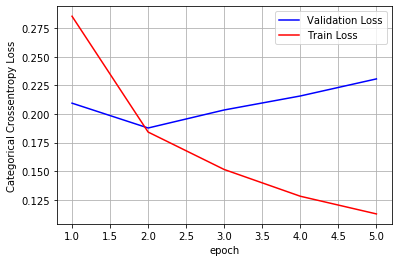

In [89]:
nb_epoch=5
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)


**Building LSTM with 3 layers**

In [90]:
# Create the model with 3 layers
from keras.layers.normalization import BatchNormalization
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length))
model.add(BatchNormalization())#Batch Normalization
model.add(Dropout(0.50))#dropout
model.add(LSTM(100,return_sequences=True))#Layer1
model.add(BatchNormalization())#Batch Normalization
model.add(Dropout(0.50))#dropout
model.add(LSTM(100,return_sequences=True))#Layer2
model.add(BatchNormalization())#Batch Normalization
model.add(Dropout(0.40))#dropout
model.add(LSTM(100))#Layer3
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 600, 32)           1469120   
_________________________________________________________________
batch_normalization_5 (Batch (None, 600, 32)           128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 600, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
batch_normalization_6 (Batch (None, 600, 100)          400       
_________________________________________________________________
dropout_6 (Dropout)          (None, 600, 100)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 600, 100)         

In [91]:
# Fitting the model
history = model.fit(X_train, Y_train, epochs =3, batch_size = 64, verbose=1,validation_data=(X_test, Y_test))
scores = model.evaluate(X_test, Y_test, verbose = 0)


Train on 61441 samples, validate on 26332 samples
Epoch 1/3
61441/61441 [==============================] - 3203s 52ms/step - loss: 0.3113 - acc: 0.8736 - val_loss: 0.2562 - val_acc: 0.8891
Epoch 2/3
61441/61441 [==============================] - 3245s 53ms/step - loss: 0.1973 - acc: 0.9225 - val_loss: 0.2015 - val_acc: 0.9235
Epoch 3/3
61441/61441 [==============================] - 3258s 53ms/step - loss: 0.1636 - acc: 0.9361 - val_loss: 0.2171 - val_acc: 0.9166


In [92]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

Test score: 0.21714939511367368
Test accuracy: 0.9166413489562227


Test score: 0.21714939511367368
Test accuracy: 0.9166413489562227


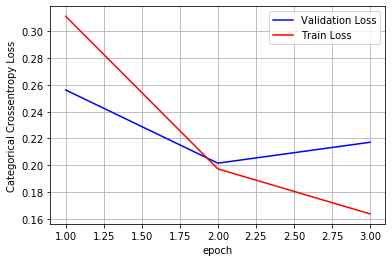

In [93]:
nb_epoch=3
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

**Conclusions**

In [0]:
from prettytable import PrettyTable

In [0]:
x=PrettyTable()

In [0]:
x.field_names=['Neural_Network_Type','#_of_Layers','Optimizer','Test_Score','Test_Accuracy']

In [0]:
x.add_row(['LSTM',2,'adam',0.23,92.13])
x.add_row(['LSTM',3,'adam',0.21,91.66])

In [98]:
print(x)

+---------------------+-------------+-----------+------------+---------------+
| Neural_Network_Type | #_of_Layers | Optimizer | Test_Score | Test_Accuracy |
+---------------------+-------------+-----------+------------+---------------+
|         LSTM        |      2      |    adam   |    0.23    |     92.13     |
|         LSTM        |      3      |    adam   |    0.21    |     91.66     |
+---------------------+-------------+-----------+------------+---------------+
